In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

!pip install opencv-python

import cv2
import random
import GPyOpt as gy
import noise as ns

tf.get_logger().setLevel('ERROR')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os



mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()

Num GPUs Available:  1


True

In [ ]:
from Detection.shared import randomimg,binary_search,norm,perlin_noise,display_images,colorize
randomimg()
z = perlin_noise(23,2,10)
display_images(np.expand_dims(z,0))

temp = np.expand_dims(z,0)
print(temp.shape)
temp = colorize(temp[0],0.3)
temp = np.expand_dims(z,0)
print(temp.shape)
display_images(temp)

In [ ]:
def create_distorted_image(image, typ, epsilon, parameters):
    parameters = parameters[0]
    if typ == 'perlin':
        pert = perlin_noise(parameters[0], parameters[1], parameters[2])
    elif typ == 'gabor':
        pert = gabor_noise_random(int(parameters[0]), int(parameters[1]), parameters[2], parameters[3], parameters[4], sides = int(parameters[5]))
    pert = (pert-.5)*2
    dist_img = image + epsilon*pert
    return dist_img


from scipy.ndimage import gaussian_filter

i = randomimg()
display_images(i.img)
n = create_distorted_image(i.img, "perlin", 16/255, [[23,23,5,np.pi/2, 20, 1]])
print(norm(n, i.img)[1])
display_images(n)

In [6]:

import matplotlib.pyplot as pl

class preddifference:
    def __init__(self, image, maxnorm,noise,constraint='l2'):
        self.image = image
        self.maxnorm = maxnorm
        self.noise = noise
        self.best = float('inf')
        self.theta = 0.01
        pass
    def func(self, parameters):
        final = create_distorted_image(self.image.img, self.noise, self.maxnorm/255, parameters)
        
        out,dist = binary_search(final, self.image, self.theta, l='linf')
        if dist<self.best:
            self.best=dist
            self.adv = out
        #return np.log(dist*(255/self.maxnorm))
        return dist

In [7]:
import time
def millis():
    return int(round(time.time() * 1000))

def bayesian_attack(image, max_query, init_query, noise, max_norm, graph_test = False):
    if noise == 'perlin':
        bounds = [{'name' : 'wavelength', 'type' : 'continuous', 'domain' : (200, 10), 'dimensionality' : 1},
                {'name' : 'octave'  , 'type' : 'discrete'  , 'domain' : (1,2,3,4), 'dimensionality' : 1},
               # {'name' : 'persistence'  , 'type' : 'continuous'  , 'domain' : (0, 2), 'dimensionality' : 1},
               # {'name' : 'lac'  , 'type' : 'continuous'  , 'domain' : (0, 4), 'dimensionality' : 1},
                {'name' : 'freq_sine', 'type' : 'continuous', 'domain' : (4, 32), 'dimensionality' : 1}
                #{'name' : 'guassian_std', 'type' : 'continuous', 'domain' : (0, 5), 'dimensionality' : 1}

                ]
    elif noise == 'gabor':
        bounds = [{'name' : 'kernels', 'type' : 'discrete', 'domain' : (200, 1), 'dimensionality' : 1},
                {'name' : 'kernel size'  , 'type' : 'discrete'  , 'domain' : (1,40), 'dimensionality' : 1},
                {'name' : 'sigma'  , 'type' : 'continuous'  , 'domain' : (1, 8), 'dimensionality' : 1},
                {'name' : 'orientation'  , 'type' : 'continuous'  , 'domain' : (0, 2*np.pi), 'dimensionality' : 1},
                {'name' : 'scale', 'type' : 'continuous', 'domain' : (1, 20), 'dimensionality' : 1},
                {'name' : 'sides', 'type' : 'discrete', 'domain' : (1,12), 'dimensionality': 1}
                ]

    
    feasible_space = gy.Design_space(space = bounds)        
    initial_design = gy.experiment_design.initial_design('random', feasible_space, init_query)

    queries = 0
    
    disttbl = []
    
    optimized = preddifference(image, max_norm,noise = noise)

    # Gaussian process and Bayesian optimization
    objective = gy.core.task.SingleObjective(optimized.func, num_cores = 1)
    model = gy.models.GPModel(exact_feval = False, optimize_restarts = 5, verbose = False)
    aquisition_opt = gy.optimization.AcquisitionOptimizer(feasible_space)
    acquisition = gy.acquisitions.AcquisitionLCB(model, feasible_space, optimizer = aquisition_opt)
    evaluator = gy.core.evaluators.Sequential(acquisition, batch_size = 1)

    #im = create_distorted_image(image, 'perlin', .05, [100, 3, 1, 2, 20])
    #display_images(im)

    BOpt = gy.methods.ModularBayesianOptimization(model, feasible_space, objective, acquisition, evaluator, initial_design)
    HistoryL2 = []
    HistoryLinf = []
    bestDistanceL2 = 2550
    bestDistanceLinf = 2550
    best_f=float('inf')
    TimeHistory = [[0,0]]
    t1 = millis()
    while image.q < max_query:
        queries+=1
        BOpt.run_optimization(max_iter = 1)
        t2 = millis()
        TimeHistory.append([image.q,t2-t1])
        if BOpt.fx_opt < best_f:
            best_f = BOpt.fx_opt
            twonorm, infnorm = norm(image.img,optimized.adv)
            if infnorm < bestDistanceLinf:
                bestDistanceLinf=infnorm
                HistoryLinf.append([image.q,bestDistanceLinf])
            if twonorm<bestDistanceL2:
                bestDistanceL2=twonorm
                HistoryL2.append([image.q,bestDistanceL2])
                final = optimized.adv


    twonorm, infnorm = norm(image.img,final)
    success = best_f
    HistoryL2.append([image.q,bestDistanceL2])
    HistoryLinf.append([image.q,bestDistanceLinf])
    return success, queries,  twonorm, infnorm, final,[HistoryL2,HistoryLinf,TimeHistory]


In [8]:
def randomproc(imgobj, noise, max_norm, queries):
    
    for k in range(1,queries):
        params = []
        if k % 10 == 0: print("Random Attack Query "+str(k))
        if noise == 'perlin':
            params.append(np.random.uniform(10,200))
            params.append(np.random.randint(1,4))
            params.append(np.random.uniform(4,32))
        pert = create_distorted_image(imgobj.img, noise, max_norm, [params])
        out = imgobj.decision(pert)
        if out:
            print("Random Attack Success!")
            return 1.0, queries
    
    print("Random Attack Failure!")
    return 0.0, queries


import pickle
def SAVE(fp,input):
    with open(fp, "wb+") as fp:
        pickle.dump(input, fp)
    return


def LOAD(fp):
    with open(fp, "rb+") as fp:
        output = pickle.load(fp)
    return output

In [9]:
from  keras.preprocessing.image import save_img
noise = 'perlin'
random.seed(42)

NumberOfTest = 100
FileName = "./ver3_1000_inf_ver2"
HISTORY = []
#SAVE(FileName,HISTORY)

0.015686333179473877 252 5.7452526 0.015686333
i:0 Len(HISTORY):1
0.125490203499794 239 34.022064 0.1254902
i:1 Len(HISTORY):2
0.05490198731422424 332 16.276823 0.054901987
i:2 Len(HISTORY):3
0.007843166589736938 254 2.9628928 0.007843167
i:3 Len(HISTORY):4
0.05490201711654663 422 16.288656 0.054902017
i:4 Len(HISTORY):5
0.1254901885986328 270 32.234673 0.12549022
i:5 Len(HISTORY):6
0.007843196392059326 253 2.9599762 0.007843196
i:6 Len(HISTORY):7
0.0627451092004776 450 17.225218 0.06274511
i:7 Len(HISTORY):8
0.007843166589736938 256 2.963475 0.007843167
i:8 Len(HISTORY):9
0.03137260675430298 275 10.735937 0.031372607
i:9 Len(HISTORY):10
0.007843166589736938 250 2.958789 0.007843167
i:10 Len(HISTORY):11
0.1254901885986328 341 33.954388 0.12549019
i:11 Len(HISTORY):12
0.03137260675430298 270 10.705667 0.031372607
i:12 Len(HISTORY):13
0.015686333179473877 282 5.7462735 0.015686333
i:13 Len(HISTORY):14
0.023529469966888428 253 8.364399 0.02352947
i:14 Len(HISTORY):15
0.05490198731422424 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007843196392059326 243 2.9562747 0.007843196
i:99 Len(HISTORY):100
jellyfish: 0.47569996
pretzel: 0.16423343
necklace: 0.09777093
chain: 0.06706842
hair_slide: 0.055040278
coil: 0.0242712


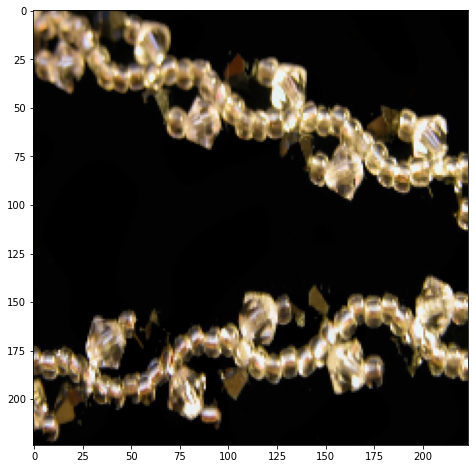

In [10]:
for i in range(NumberOfTest):
    image = randomimg()
    with tf.device('/GPU:0'): 
        temp1,temp2,temp3,temp4,returning,History = bayesian_attack(image, 1000,5,'perlin', 16)
        print(temp1,temp2,temp3,temp4)
        np.save('./Result/AdversaryExample/Ver3_1000_inf_ver2'+str(i),returning)
        HISTORY.append(History)
    print('i:{0} Len(HISTORY):{1}'.format(i,len(HISTORY)))
    if i%10==0:
        SAVE(FileName,HISTORY)
SAVE(FileName,HISTORY)    
display_images(returning)

5.550228118896484 113 5.550228 0.022549033


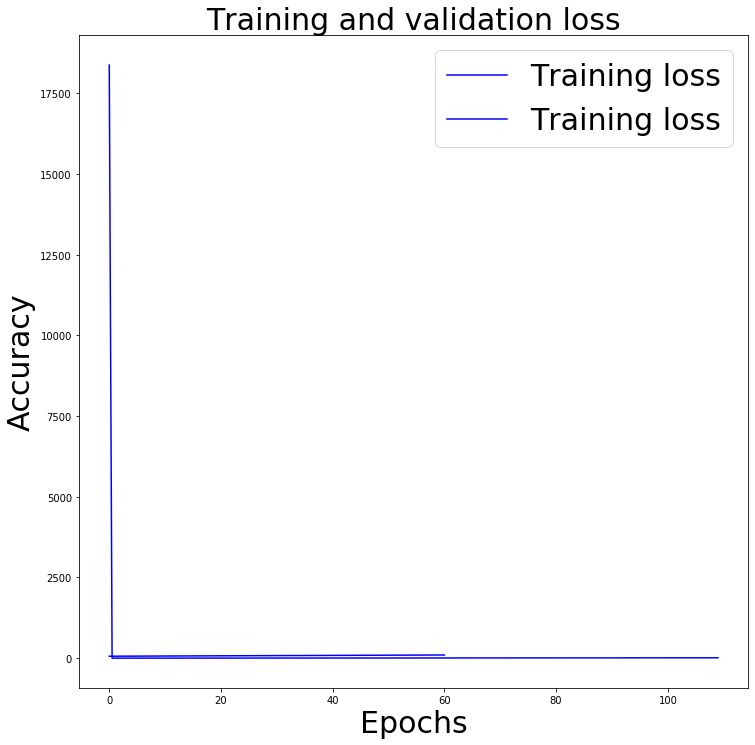

NameError: name 'TimeHistory' is not defined

In [10]:
print(temp1,temp2,temp3,temp4)
import matplotlib.pyplot as plt
X = [i[0] for i in History]
Y = [i[1] for i in History]

plt.figure(figsize=(12,12))
plt.plot(X,Y, 'b-', label='Training loss')
#plt.plot(epochs, val_loss_values, 'rs-', label='Validation loss')
plt.title('Training and validation loss',size=30)
plt.xlabel('Epochs',size=30)
plt.ylabel('Accuracy',size=30)
plt.legend(fontsize = 30 )
#plt.savefig("./res_1.pdf", bbox_inches='tight', pad_inches=0)
plt.show();


X = [i[0] for i in TimeHistory]
Y = [i[1]/1000 for i in TimeHistory]

plt.figure(figsize=(12,12))
plt.plot(X,Y, 'b-', label='Training loss')
#plt.plot(epochs, val_loss_values, 'rs-', label='Validation loss')
plt.title('Training and validation loss',size=30)
plt.xlabel('Epochs',size=30)
plt.ylabel('Accuracy',size=30)
plt.legend(fontsize = 30 )
#plt.savefig("./res_1.pdf", bbox_inches='tight', pad_inches=0)
plt.show();

In [ ]:
import pickle
def SAVE(fp,input):
    with open(fp, "wb") as fp:
        pickle.dump(input, fp)
    return


def LOAD(fp):
    with open(fp, "rb") as fp:
        output = pickle.load(fp)
    return output
SAVE('./Ver1',History)
SAVE('./Ver1_time',TimeHistory)

In [ ]:
maxquery = 100
initquery = 5
np.random.seed(0)
noise = 'perlin'
max_norm=16

test_size = 100
totalinfnorm = 0
totalquery = 0
total2norm = 0
successes = 0
controlsuccesses = 0
totalrquery= 0
k=0
for k in range(test_size-1):
    image = randomimg()
    with tf.device('/GPU:0'): 
        temp1,temp2,temp3,temp4,returnimg = bayesian_attack(image, maxquery,initquery,noise, max_norm)
        temp5, temp6 = randomproc(image, noise, max_norm/255, initquery+maxquery)
    successes+=temp1
    controlsuccesses += temp5
    if temp1 != 0:
        totalquery+=temp2
        total2norm+=temp3
        totalinfnorm+=temp4
    if temp5 != 0:
        totalrquery += temp6
    if k % 10 == 0 and k != 0: 
        print("Image"+str(k))
        display_images(returnimg)

avgquery =(totalquery/successes)
avg2norm =(total2norm/successes)
avginfnorm =(totalinfnorm/successes)
successrate = successes/test_size
randomrate = controlsuccesses/test_size
avgrquery = totalrquery/controlsuccesses

print("Success Rate: (Optimized)"+str(successrate))
print("Success Rate (Random)"+str(randomrate))
print("Average Queries (Optimized): "+str(avgquery+initquery))
print("Average Queries (Random): "+str(avgrquery))
print("Average 2 Norm: "+str(avg2norm))
print("Average Infinity Norm: "+str(avginfnorm))

In [ ]:
print("Success Rate: "+str(successrate))
print("Average queries: "+str(avgquery))
print("Average 2 Norm: "+str(avg2norm))
print("Average Infinity Norm: "+str(avginfnorm))

In [ ]:
print(avginfnorm)